# Conditional DCGAN on MNIST

## Project Overview
This notebook implements a **Conditional Deep Convolutional Generative Adversarial Network (cDCGAN)** trained on the MNIST dataset. Unlike a standard GAN, this model allows **controlled generation of specific digits (0–9)** by conditioning the generator and discriminator on class labels.

The result is a **labeled synthetic data generator** capable of producing realistic handwritten digit images with correct labels. This technique is widely used for **data augmentation, synthetic dataset creation, and controllable content generation**.

## Key Idea

In a regular GAN:
```
z → Generator → Fake Image
```
The generator has no control over what type of image is produced.

In a **Conditional GAN**:
```
(z , label) → Generator → Fake Image of that label
```
Both the generator and discriminator receive label information, forcing the model to learn the relationship between **class labels and image appearance**.

## Architecture Summary

### Generator
- Inputs: Random noise vector `z` and target digit label `y`
- Label is encoded as **one-hot vector** and concatenated with noise
- Uses **fully connected projection + transposed convolutions** to upsample into a 28×28 image
- Output: Fake MNIST-like image of the requested digit

### Discriminator
- Inputs: Image and corresponding label
- Label is expanded into **label feature maps** and concatenated as extra channels to the image
- Uses **convolutional layers** to extract features
- Outputs probability whether the image is real or fake **and matches the given label**

This label-as-channel injection ensures strong conditioning and prevents label–image mismatch during training.

## Training Procedure

Each training iteration consists of two steps:

### 1. Train Discriminator
- Receives real images with correct labels → should output *real*
- Receives generated images with fake labels → should output *fake*
- Learns to distinguish real vs fake **and verify label consistency**

### 2. Train Generator
- Generates images from random noise + random labels
- Passes them to discriminator
- Learns to produce images that discriminator classifies as *real* for the given label

Binary Cross-Entropy (BCE) loss is used for both networks.

## Practical Applications

### 1. Data Augmentation
Generate additional labeled samples to improve classifier performance when real data is limited.

### 2. Synthetic Dataset Creation
Create balanced datasets with equal samples per class.

### 3. Anomaly Detection
GAN learns normal data distribution — poor reconstructions indicate anomalies.

### 4. Portfolio Project
Demonstrates mastery of:
- GAN training
- Conditional generation
- GPU acceleration
- Synthetic data pipelines

---


Using device: cuda
Epoch [1/40] completed in 7.18 sec
Epoch [2/40] completed in 6.90 sec
Epoch [3/40] completed in 6.77 sec
Epoch [4/40] completed in 6.69 sec
Epoch [5/40] completed in 6.63 sec


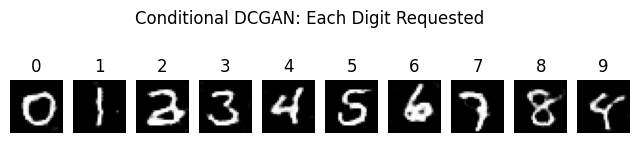

Epoch [6/40] completed in 7.40 sec
Epoch [7/40] completed in 6.55 sec
Epoch [8/40] completed in 6.60 sec
Epoch [9/40] completed in 6.76 sec
Epoch [10/40] completed in 6.94 sec


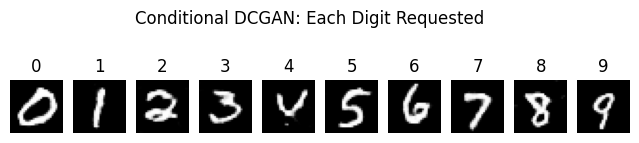

Epoch [11/40] completed in 6.18 sec
Epoch [12/40] completed in 6.63 sec
Epoch [13/40] completed in 6.35 sec
Epoch [14/40] completed in 6.61 sec
Epoch [15/40] completed in 6.65 sec


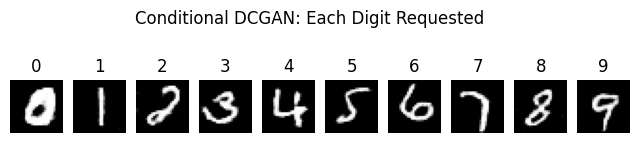

Epoch [16/40] completed in 6.49 sec
Epoch [17/40] completed in 6.57 sec
Epoch [18/40] completed in 6.35 sec
Epoch [19/40] completed in 6.88 sec
Epoch [20/40] completed in 6.56 sec


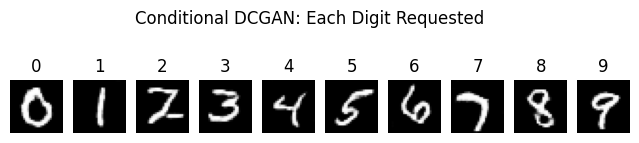

Epoch [21/40] completed in 6.37 sec
Epoch [22/40] completed in 6.66 sec
Epoch [23/40] completed in 7.19 sec
Epoch [24/40] completed in 6.34 sec
Epoch [25/40] completed in 6.86 sec


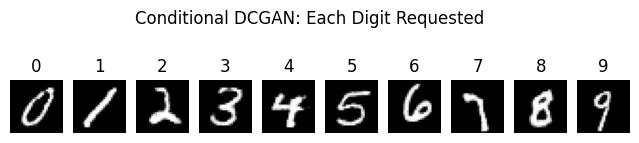

Epoch [26/40] completed in 6.85 sec
Epoch [27/40] completed in 6.43 sec
Epoch [28/40] completed in 7.24 sec
Epoch [29/40] completed in 7.05 sec
Epoch [30/40] completed in 6.31 sec


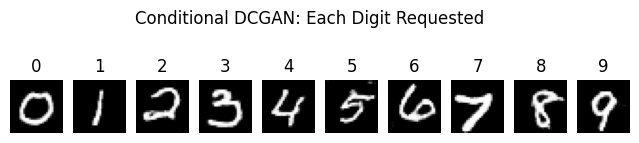

Epoch [31/40] completed in 6.43 sec
Epoch [32/40] completed in 6.67 sec
Epoch [33/40] completed in 7.01 sec
Epoch [34/40] completed in 6.52 sec
Epoch [35/40] completed in 6.88 sec


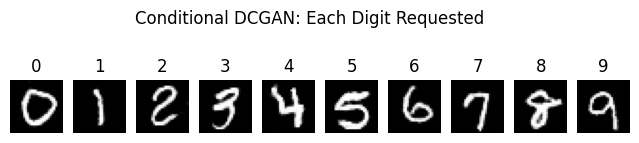

Epoch [36/40] completed in 6.54 sec
Epoch [37/40] completed in 6.43 sec
Epoch [38/40] completed in 6.55 sec
Epoch [39/40] completed in 6.91 sec
Epoch [40/40] completed in 6.54 sec


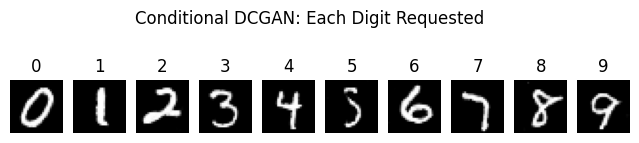

Training Complete!


In [ ]:
# ==================================================
# 0) Device Setup
# ==================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ==================================================
# 1) Imports
# ==================================================
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time

# ==================================================
# 2) Hyperparameters
# ==================================================
latent_dim = 100
num_classes = 10
batch_size = 128
epochs = 40
learning_rate = 0.0002

# ==================================================
# 3) Dataset Loading
# ==================================================
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    transform=transform,
    download=True
)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

# ==================================================
# 4) Conditional Generator
# ==================================================
class ConditionalGenerator(nn.Module):
    def __init__(self, latent_dim, num_classes):
        super().__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes) # vector لكل lable

        self.project = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 128 * 7 * 7),
            nn.ReLU(True)
        )

        self.net = nn.Sequential(

            # Unflatten the latent vector
            # Input shape:  (batch_size, 128*7*7)
            # Output shape: (batch_size, 128, 7, 7)
            # 128 = number of feature maps
            # 7x7 = small spatial grid to start image reconstruction
            nn.Unflatten(1, (128, 7, 7)),


            # Transposed Convolution (upsampling layer)
            # in_channels = 128  → input feature maps
            # out_channels = 64 → reduce channel depth gradually
            # kernel_size = 4   → 4x4 filter
            # stride = 2        → doubles spatial size
            # padding = 1       → keeps scaling symmetric
            # Result: 7x7 → 14x14
            nn.ConvTranspose2d(128, 64, 4, 2, 1),


            # Batch Normalization on 64 channels
            # Stabilizes and speeds up training
            nn.BatchNorm2d(64),


            # ReLU activation
            # Adds non-linearity and keeps positive activations
            nn.ReLU(True),


            # Second upsampling layer
            # in_channels = 64
            # out_channels = 1 → single-channel grayscale image
            # kernel_size = 4, stride = 2, padding = 1
            # Result: 14x14 → 28x28
            nn.ConvTranspose2d(64, 1, 4, 2, 1),


            # Tanh activation
            # Outputs values in [-1, +1]
            # Used because images are usually normalized to this range
            nn.Tanh()
        )

    def forward(self, z, labels):
        label_vec = self.label_emb(labels)
        x = torch.cat((z, label_vec), dim=1)
        x = self.project(x)
        img = self.net(x)
        return img

# ==================================================
# 5) Conditional Discriminator
# ==================================================
class ConditionalDiscriminator(nn.Module):
def __init__(self, num_classes):
    super().__init__()
    self.num_classes = num_classes  # Number of class labels in Conditional GAN

    # Discriminator Network
    self.net = nn.Sequential(

        # Input channels = 1 (grayscale image) + num_classes (label channels)
        # Example: MNIST -> 1 + 10 = 11 input channels (image ch 1:grayscale , label 10: Label ch)
        nn.Conv2d(1 + num_classes, 64, 4, 2, 1),  # 10+1 فوق الصورة1  حطينا 10ورقات شفافةبالترتيب، في وحدة منها مكتوب عليها

        # Conv2d(in_channels=1+num_classes, out_channels=64, kernel_size=4, stride=2, padding=1)
        # Kernel size = 4x4 filter
        # Stride = 2 → halves spatial size (28x28 → 14x14)
        # Padding = 1 → keeps scaling symmetric
        # Output shape: [64, 14, 14]

        nn.LeakyReLU(0.2, inplace=True),
        # LeakyReLU with slope 0.2 for negative values
        # Prevents "dying ReLU" problem

        nn.Conv2d(64, 128, 4, 2, 1),
        # in_channels = 64  → input feature maps
        # out_channels = 128 → deeper feature extraction
        # kernel_size = 4x4
        # stride = 2 → 14x14 → 7x7
        # padding = 1
        # Output shape: [128, 7, 7]

        nn.BatchNorm2d(128),
        # Normalizes feature maps across the batch
        # Stabilizes and speeds up GAN training

        nn.LeakyReLU(0.2, inplace=True),

        nn.Flatten(),
        # Flattens [128, 7, 7] → 128*7*7 = 6272 features

        nn.Linear(128 * 7 * 7, 1),
        # Fully connected layer
        # Maps 6272 features → 1 output neuron

        nn.Sigmoid()
        # Converts output to probability between 0 and 1
        # 1 → real image
        # 0 → fake image
    )


    def forward(self, img, labels):
        # Convert labels to one-hot maps
        label_maps = torch.nn.functional.one_hot(labels, num_classes=self.num_classes)
        label_maps = label_maps.float().view(labels.size(0), self.num_classes, 1, 1)
        label_maps = label_maps.expand(-1, -1, 28, 28) # batch, 10, 28*28

        # Concatenate label maps as channels

        # image [1,28,28]
        # label [10,28,28]
        # cat(image, label,dim =1) = [11,28,28]
        d_input = torch.cat((img, label_maps), dim=1)

        return self.net(d_input)

# ==================================================
# 6) Initialize Models
# ==================================================
G = ConditionalGenerator(latent_dim, num_classes).to(device)
D = ConditionalDiscriminator(num_classes).to(device)

loss_fn = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# ==================================================
# 7) Visualization Function
# ==================================================
def show_generated_digits(generator):
    generator.eval()
    z = torch.randn(10, latent_dim, device=device)
    labels = torch.tensor([0,1,2,3,4,5,6,7,8,9], device=device)

    with torch.no_grad():
        fake_imgs = generator(z, labels)

    fake_imgs = fake_imgs.squeeze().cpu().numpy()

    plt.figure(figsize=(8,2))
    for i in range(10):
        plt.subplot(1,10,i+1)
        plt.imshow(fake_imgs[i], cmap="gray")
        plt.title(str(i))
        plt.axis("off")
    plt.suptitle("Conditional DCGAN: Each Digit Requested")
    plt.show()

    generator.train()

# ==================================================
# 8) Training Loop
# ==================================================
for epoch in range(epochs):
    start_time = time.time()

    for real_imgs, real_labels in train_loader:

        real_imgs = real_imgs.to(device)
        real_labels = real_labels.to(device)

        batch_size_now = real_imgs.size(0)

        valid = torch.ones(batch_size_now, 1, device=device)
        fake = torch.zeros(batch_size_now, 1, device=device)

        # ---------------------
        # Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        real_pred = D(real_imgs, real_labels)
        d_real_loss = loss_fn(real_pred, valid)

        z = torch.randn(batch_size_now, latent_dim, device=device)
        fake_labels = torch.randint(0, num_classes, (batch_size_now,), device=device)
        fake_imgs = G(z, fake_labels)

        fake_pred = D(fake_imgs.detach(), fake_labels)
        d_fake_loss = loss_fn(fake_pred, fake)

        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        optimizer_D.step()

        # ---------------------
        # Train Generator
        # ---------------------
        optimizer_G.zero_grad()

        z = torch.randn(batch_size_now, latent_dim, device=device)
        gen_labels = torch.randint(0, num_classes, (batch_size_now,), device=device)
        gen_imgs = G(z, gen_labels)

        pred = D(gen_imgs, gen_labels)
        g_loss = loss_fn(pred, valid)

        g_loss.backward()
        optimizer_G.step()

    # ---- Epoch End ----
    epoch_time = time.time() - start_time
    print(f"Epoch [{epoch+1}/{epochs}] completed in {epoch_time:.2f} sec")

    # Show images every 5 epochs
    if (epoch + 1) % 5 == 0:
        show_generated_digits(G)

print("Training Complete!")

### ConvTranspose2D Output Size Formula

For each spatial dimension:

Output = (Input - 1) * Stride - 2 * Padding + Kernel_Size + Output_Padding

---

**Example from our model:**

Input = 7  
Stride = 2  
Padding = 1  
Kernel Size = 4  
Output Padding = 0  

Calculation:

(7 - 1) * 2 - 2 * 1 + 4  
= 6 * 2 - 2 + 4  
= 12 - 2 + 4  
= 14

So:

7 x 7  →  14 x 14

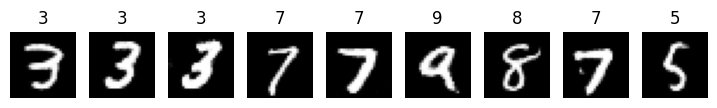

In [ ]:
z = torch.randn(9, latent_dim, device=device)
labels = torch.tensor([3,3,3,7,7,9,8,7,5], device=device)

with torch.no_grad():
    images = loaded_G(z, labels)

imgs = images.squeeze().cpu().numpy()

plt.figure(figsize=(9,2))
for i in range(9):
    plt.subplot(1,9,i+1)
    plt.imshow(imgs[i], cmap="gray")
    plt.title(str(labels[i].item()))
    plt.axis("off")
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
save_path = "/content/drive/MyDrive/conditional_dcgan_mnist.pth"
torch.save(G.state_dict(), save_path)

print("Generator saved to Drive:", save_path)


Generator saved to Drive: /content/drive/MyDrive/conditional_dcgan_mnist.pth


In [ ]:
loaded_G = ConditionalGenerator(latent_dim, num_classes).to(device)
loaded_G.load_state_dict(torch.load("/content/drive/MyDrive/conditional_dcgan_mnist.pth"))
loaded_G.eval()
print("Generator loaded from Drive!")

Generator loaded from Drive!


In [ ]:
import os
from torchvision.utils import save_image

output_dir = "/content/drive/MyDrive/Generated_MNIST"
os.makedirs(output_dir, exist_ok=True)

z = torch.randn(100, latent_dim, device=device)
labels = torch.randint(0, 10, (100,), device=device)

with torch.no_grad():
    imgs = loaded_G(z, labels)

for i in range(100):
    save_image(imgs[i], f"{output_dir}/img_{i}_label_{labels[i].item()}.png")

print("Images saved to:", output_dir)


Images saved to: /content/drive/MyDrive/Generated_MNIST
